In [182]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

import seaborn as sns

import pickle

In [183]:
nba_data = pd.read_csv('Finalized_nba_data_for_modeling.csv', index_col = 0)

In [3]:
nba_data['TS%'] = [x/10 for x in nba_data['TS%']]

# Creating Target and Feature Variables after EDA

In [160]:
target = nba_data['W']

In [161]:
features_list = []

In [162]:
for x in nba_data.columns:
    if (x == 'W') or (x == 'Tm') or (x == 'year') or (x == 'Pace'):
        pass
    else:
        features_list.append(x)

In [163]:
features = nba_data[features_list]

# Running first model with simplified data (no interactions)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=23,test_size=0.2)  

# Creating a Scalar

In [165]:
scaler = StandardScaler()
final_scaler = scaler.fit(X_train)
X_train =pd.DataFrame(data=scaler.transform(X_train), columns=features_list)
X_test =pd.DataFrame(data=scaler.transform(X_test), columns=features_list)

# Standard Regression Model

In [166]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error((y_train), y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

y_pred = lm.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error((y_test), y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', float(train_rmse), "vs. Testing: ", float(test_rmse))

Training Root Mean Squared Error: 7.204760665770511
Testing Root Mean Squared Error: 9.145229541758328
Training:  7.204760665770511 vs. Testing:  9.145229541758328


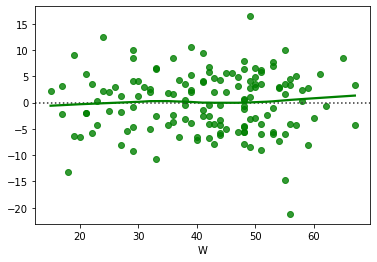

In [11]:
sns.residplot(y_train, y_train_pred,lowess=True, color="g")

# Recurvise Elimination Feature

In [12]:
from sklearn.feature_selection import RFECV

In [13]:
ols = linear_model.LinearRegression()

In [14]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [15]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [16]:
list(removed_rfe)

['3P%', '3PAr', 'FTr']

In [17]:
len(selected_rfe)

10

In [18]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_train_pred_rfe = lm_rfe.predict(X_train[selected_rfe])

train_rmse_rfe = np.sqrt(metrics.mean_squared_error((y_train), y_train_pred_rfe))


print('Training Root Mean Squared Error:' , train_rmse_rfe)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

test_rmse_rfe = np.sqrt(metrics.mean_squared_error((y_test), y_pred_rfe))

print('Testing Root Mean Squared Error:' , test_rmse_rfe)


print("vs. Testing: ", float(test_rmse), 
      "vs. Testing rfe: ", float(test_rmse_rfe))

Training Root Mean Squared Error: 7.214710999838885
Testing Root Mean Squared Error: 9.273919835681493
vs. Testing:  9.14522954175832 vs. Testing rfe:  9.273919835681493


# KBest Selection

In [19]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=10)

selector.fit(X_train, y_train)

SelectKBest(k=10, score_func=<function f_regression at 0x1a25028cb0>)

In [20]:
selected_ftest = X_train.columns[selector.get_support()]
removed_ftest = X_train.columns[~selector.get_support()]

In [21]:
list(removed_ftest)

['ORB%', 'FT%', 'AST%']

In [22]:
len(selected_ftest)

10

In [23]:
#instantiate a linear regression object
lm_ftest = LinearRegression()

#fit the linear regression to the data
lm_ftest = lm_ftest.fit(X_train[selected_ftest], y_train)

y_train_pred_ftest = lm_ftest.predict((X_train[selected_ftest]))

train_rmse_ftest = np.sqrt(metrics.mean_squared_error((y_train), y_train_pred_ftest))


print('Training Root Mean Squared Error:' , train_rmse_ftest)

y_pred_ftest = lm_ftest.predict((X_test[selected_ftest]))

test_rmse_ftest = np.sqrt(metrics.mean_squared_error((y_test), y_pred_ftest))

print('Testing Root Mean Squared Error:' , test_rmse_ftest)


print("vs. Testing: ", float(test_rmse), 
      "vs. Testing rfe: ", float(test_rmse_rfe),
      "vs. Testing ftest: ", float(test_rmse_ftest))

Training Root Mean Squared Error: 8.031757583830958
Testing Root Mean Squared Error: 10.546659080792182
vs. Testing:  9.14522954175832 vs. Testing rfe:  9.273919835681493 vs. Testing ftest:  10.546659080792182


# Applying VIF 

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [25]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.round(5)

,VIF Factor,features
0,1.50865,Age
1,1.65504,ORB%
2,1.84654,3P%
3,1.68216,FT%
4,1.79176,TOV
5,1.95845,PTS
6,2.45823,TS%
7,2.29741,3PAr
8,1.31267,FTr
9,1.82156,TRB%


# Lasso Method

In [26]:
from sklearn.linear_model import Lasso

In [27]:
lasso = Lasso(alpha=0.01, max_iter = 5000, normalize=False)

final_lasso = lasso.fit(X_train,y_train)

y_train_pred_lasso = lasso.predict(X_train)
y_pred_lasso = lasso.predict(X_test)

train_rmse = metrics.mean_absolute_error(y_train, y_train_pred_lasso)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
print('Training Error: '+ str(train_rmse))
print('Testing Error: '+ str(test_rmse))

Training Error: 5.6928723119656475
Testing Error: 9.154810777411988


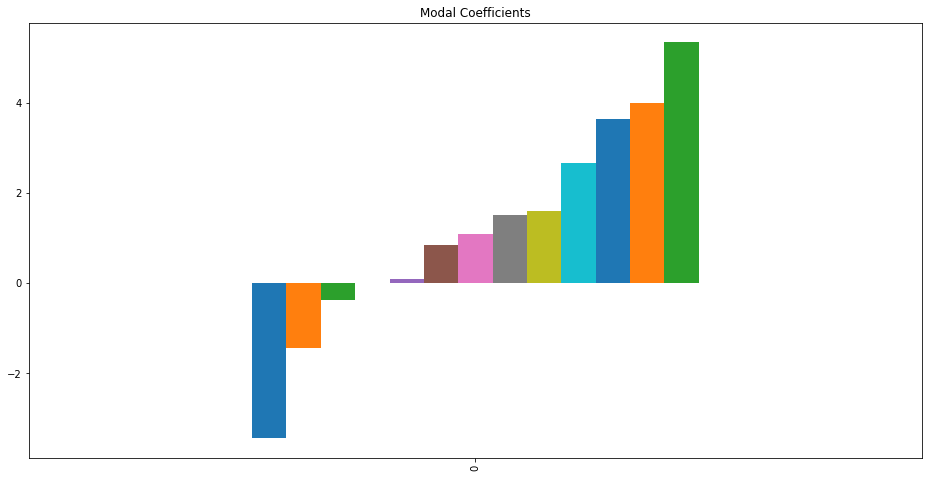

In [28]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [29]:
lasso_coef01.T

,0
TOV,-3.437336
FT%,-1.450160
FTr,-0.379354
3P%,0.008787
3PAr,0.083243
BLK%,0.830888
AST%,1.089062
STL%,1.514579
TRB%,1.601759
PTS,2.655245


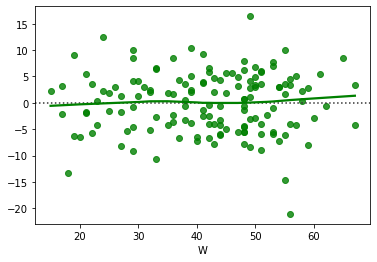

In [30]:
sns.residplot( y_train, y_train_pred_lasso,lowess=True, color="g")

# Statsmodels to get *R^2* value

In [31]:
X_endog = sm.add_constant(X_test)

In [32]:
res = sm.OLS(list(y_test), X_endog)

In [33]:
res.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     5.441
Date:                Wed, 06 May 2020   Prob (F-statistic):           0.000261
Time:                        20:02:32   Log-Likelihood:                -119.54
No. Observations:                  36   AIC:                             267.1
Df Residuals:                      22   BIC:                             289.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.6967      1.757     23.158      0.000      37.052      44.341
Age            5.4829      2.519      2.176      0.041       0.258      10.708
ORB%           3.4481      2.504      1.377      0.182      -1.744       8.640
3P%            2.4901      1.582      1.574      0.130      -0.792       5.772
FT%           -2.9466      2.095     -1.406      0.174      -7.292       1.399
TOV           -3.8222      2.816     -1.357      0.188      -9.662       2.018
PTS           -1.3577      1.753     -0.774      0.447      -4.993       2.278
TS%            5.0278      2.713      1.853      0.077      -0.598      10.654
3PAr          -0.4729      2.480     -0.191      0.851      -5.617       4.671
FTr            0.0624      1.988      0.031      0.975      -4.060       4.185
TRB%           1.7466      2.160      0.809      0.427      -2.733       6.226
AST%           2.8673      2.101      1.365      0.186      -1.490       7.224
STL%           1.2525      1.818      0.689      0.498      -2.518       5.023
BLK%           0.6938      1.772      0.391      0.699      -2.982       4.369
==============================================================================
Omnibus:                        0.214   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.898   Jarque-Bera (JB):                0.220
Skew:                          -0.158   Prob(JB):                        0.896
Kurtosis:                       2.782   Cond. No.                         5.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
'3PAr', 'FTr', 'BLK', 'STL'

('3PAr', 'FTr', 'BLK', 'STL')

The first model had everything included after removing from EDA analysis. After running multiple (different types of models i found that there were multiple features that could be removed, either because they had some collinearity (VIF) or because they did not have enough of an impact on the results (Lasso/Ftest/RFE)

# Test 2: 

# Removing additional features that did not do well in the first run

In [35]:
nba_data.columns

Index(['Age', 'W', 'Pace', 'ORB%', 'Tm', '3P%', 'FT%', 'TOV', 'PTS', 'TS%',
       '3PAr', 'FTr', 'TRB%', 'AST%', 'STL%', 'BLK%', 'year'],
      dtype='object')

In [36]:
nba_data_2 = nba_data.drop(columns = ['3PAr', 'FTr', 'FT%'])

# Creating Features and Target

In [37]:
target = nba_data_2['W']

In [38]:
features_list_2 = []

In [39]:
for x in nba_data_2.columns:
    if (x == 'W') or (x == 'Tm') or (x == 'year') or (x == 'Pace'):
        pass
    else:
        features_list_2.append(x)

In [40]:
features_2 = nba_data[features_list_2]

# Train test split test 2

In [41]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features_2, target, random_state=23,test_size=0.2)  

# Scaling the Data 2

In [42]:
scaler = StandardScaler()
scaler.fit(X_train_2)
X_train_2 =pd.DataFrame(data=scaler.transform(X_train_2), columns=features_list_2)
X_test_2 =pd.DataFrame(data=scaler.transform(X_test_2), columns=features_list_2)

# Statsmodel Testing

In [43]:
X_endog_2 = sm.add_constant(X_test_2)

In [44]:
res_2 = sm.OLS(list(y_test_2), X_endog_2)

In [45]:
res_2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     7.148
Date:                Wed, 06 May 2020   Prob (F-statistic):           3.26e-05
Time:                        20:02:33   Log-Likelihood:                -121.13
No. Observations:                  36   AIC:                             264.3
Df Residuals:                      25   BIC:                             281.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.6918      1.637     24.863      0.000      37.321      44.063
Age            6.2485      2.141      2.919      0.007       1.839      10.658
ORB%           3.3756      1.999      1.689      0.104      -0.740       7.492
3P%            2.5809      1.539      1.677      0.106      -0.588       5.750
TOV           -1.6666      2.302     -0.724      0.476      -6.408       3.074
PTS           -2.1869      1.618     -1.351      0.189      -5.520       1.146
TS%            5.2086      2.158      2.414      0.023       0.764       9.653
TRB%           1.9447      1.915      1.015      0.320      -1.999       5.889
AST%           1.7092      1.862      0.918      0.368      -2.126       5.545
STL%           1.1170      1.565      0.714      0.482      -2.106       4.340
BLK%           1.2240      1.474      0.830      0.414      -1.813       4.260
==============================================================================
Omnibus:                        0.894   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.640   Jarque-Bera (JB):                0.721
Skew:                          -0.334   Prob(JB):                        0.697
Kurtosis:                       2.816   Cond. No.                         4.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# VIF Factor

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [47]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_2.values, i) for i in range(X_train_2.shape[1])]
vif["features"] = X_train_2.columns
vif.round(5)

,VIF Factor,features
0,1.46944,Age
1,1.59109,ORB%
2,1.57069,3P%
3,1.67132,TOV
4,1.84286,PTS
5,2.20995,TS%
6,1.56582,TRB%
7,1.31801,AST%
8,1.41050,STL%
9,1.33261,BLK%


# Lasso Method

In [48]:
from sklearn.linear_model import Lasso

In [49]:
lasso_2 = Lasso(alpha=0.01, max_iter = 5000, normalize=False)

lasso_2.fit(X_train_2,y_train_2)

y_train_pred_lasso_2 = lasso_2.predict(X_train_2)
y_pred_lasso_2 = lasso_2.predict(X_test_2)

train_rmse_2 = metrics.mean_absolute_error(y_train_2, y_train_pred_lasso_2)
test_rmse_2 = np.sqrt(metrics.mean_squared_error(y_test_2, y_pred_lasso_2))
print('Training Error: '+ str(train_rmse_2))
print('Testing Error: '+ str(test_rmse_2))

Training Error: 5.805580391996181
Testing Error: 9.508223863268663


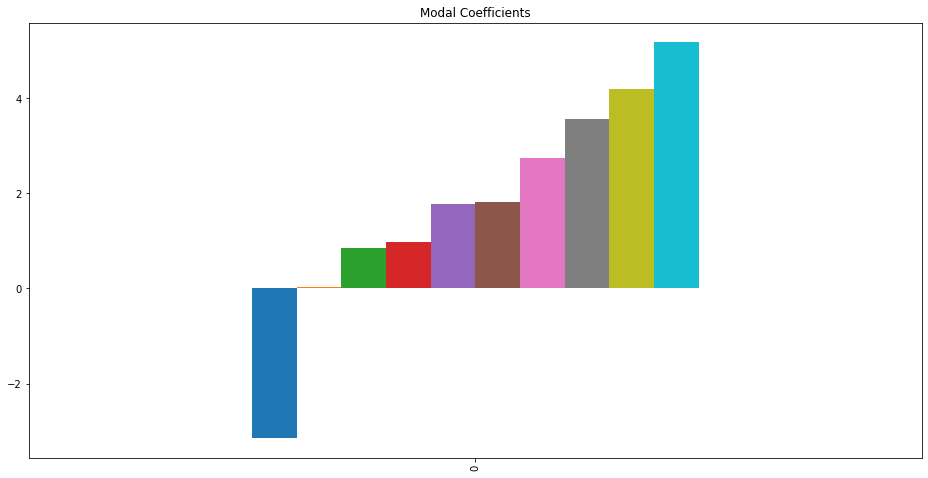

In [50]:
lasso_coef02 = pd.DataFrame(data=lasso_2.coef_).T
lasso_coef02.columns = X_train_2.columns
lasso_coef02 = lasso_coef02.T.sort_values(by=0).T
lasso_coef02.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [51]:
lasso_coef02.T

,0
TOV,-3.140466
3P%,0.039590
AST%,0.857514
BLK%,0.984312
TRB%,1.767940
STL%,1.815884
PTS,2.737111
Age,3.563983
ORB%,4.195918
TS%,5.171794


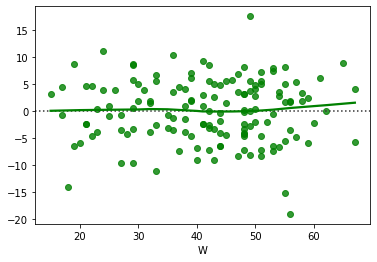

In [52]:
sns.residplot(y_train_2, y_train_pred_lasso_2,lowess=True, color="g")

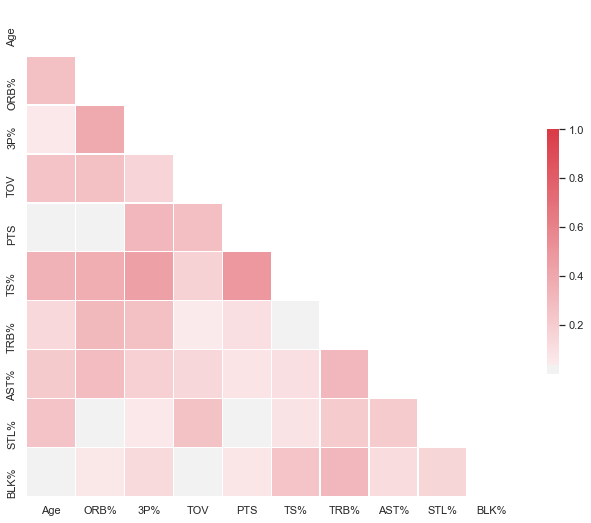

In [53]:
sns.set(style="white")


# Compute the correlation matrix
corr = np.abs(X_train_2.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [54]:
# Create correlation matrix
corr_matrix = X_train_2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,Age,ORB%,3P%,TOV,PTS,TS%,TRB%,AST%,STL%,BLK%
Age,NaN,0.271364,0.053916,0.254811,0.000604,0.347336,0.137644,0.211632,0.251010,0.009606
ORB%,NaN,NaN,0.385869,0.266518,0.021138,0.372124,0.309542,0.293840,0.005958,0.057916
3P%,NaN,NaN,NaN,0.160948,0.320172,0.441005,0.273558,0.186827,0.052032,0.125608
TOV,NaN,NaN,NaN,NaN,0.279120,0.175093,0.042942,0.147468,0.259844,0.008999
PTS,NaN,NaN,NaN,NaN,NaN,0.487256,0.103822,0.076054,0.019040,0.070252
TS%,NaN,NaN,NaN,NaN,NaN,NaN,0.014641,0.104371,0.081845,0.247779
TRB%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.315760,0.203882,0.318281
AST%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204649,0.124974
STL%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156627
BLK%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Checking Recursive method to see what values it may still remove

In [55]:
from sklearn.feature_selection import RFECV

In [56]:
ols = linear_model.LinearRegression()

In [57]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train_2, y_train_2)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [58]:
selected_rfe_2 = X_train_2.columns[selector.support_]
removed_rfe_2 = X_train_2.columns[~selector.support_]

In [59]:
list(removed_rfe_2)

['3P%', 'AST%', 'BLK%']

In [61]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe.fit(X_train_2[selected_rfe], y_train_2)

y_train_pred_rfe_2 = lm_rfe.predict(X_train_2[selected_rfe])

train_rmse_rfe_2 = np.sqrt(metrics.mean_squared_error((y_train_2), y_train_pred_rfe_2))


print('Training Root Mean Squared Error:' , train_rmse_rfe_2)

y_pred_rfe_2 = lm_rfe.predict(X_test_2[selected_rfe])

test_rmse_rfe_2 = np.sqrt(metrics.mean_squared_error((y_test_2), y_pred_rfe_2))

print('Testing Root Mean Squared Error:' , test_rmse_rfe_2)


print("vs. Testing: ", float(test_rmse_2), 
      "vs. Testing rfe: ", float(test_rmse_rfe_2))

KeyError: "['FT%'] not in index"

In [62]:
sns.residplot(y_train_2, y_train_pred_rfe_2,lowess=True, color="g")

NameError: name 'y_train_pred_rfe_2' is not defined

# Test 3 - 

# Taking all the original data from the first test and trying to create some interactions

In [121]:
nba_data_3 = nba_data

In [122]:
nba_data_3['TS_Ast'] = [nba_data_3['TS%'][i]*nba_data_3['AST%'][i] for i in range(len(nba_data_3['TS%']))]

In [123]:
nba_data_3['TS_ORB'] = [nba_data_3['TS%'][i]*nba_data_3['ORB%'][i] for i in range(len(nba_data_3['TS%']))]

In [124]:
nba_data_3['TS_Pts'] = [nba_data_3['TS%'][i]*nba_data_3['PTS'][i] for i in range(len(nba_data_3['TS%']))]

In [125]:
nba_data_3['TS%'] = [x/10 for x in nba_data_3['TS%']]

# Target and features for 3rd test

In [67]:
target = nba_data_3['W']

In [68]:
features_list_3 = []

In [69]:
for x in nba_data_3.columns:
    if (x == 'W') or (x == 'Tm') or (x == 'year') or (x == 'Pace'):
        pass
    else:
        features_list_3.append(x)

In [70]:
features_3 = nba_data_3[features_list_3]

In [71]:
X_train_3, X_test_3, y_train_3, y_test_3= train_test_split(features_3, target, random_state=23,test_size=0.2)  

In [72]:
scaler = StandardScaler()
final_scaler = scaler.fit(X_train_3)
X_train_3 =pd.DataFrame(data=scaler.transform(X_train_3), columns=features_list_3)
X_test_3 =pd.DataFrame(data=scaler.transform(X_test_3), columns=features_list_3)

# Recursive method 3

In [73]:
from sklearn.feature_selection import RFECV

In [74]:
ols = linear_model.LinearRegression()

In [75]:
# Create recursive feature eliminator that scores features by mean squared errors
selector_3 = RFECV(estimator=ols, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector_3.fit(X_train_3, y_train_3)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [76]:
selected_rfe_3 = X_train_3.columns[selector_3.support_]
removed_rfe_3 = X_train_3.columns[~selector_3.support_]

In [77]:
list(removed_rfe_3)

['3P%', '3PAr', 'FTr']

In [78]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe.fit(X_train_3[selected_rfe], y_train_3)

y_train_pred_rfe_3 = lm_rfe.predict(X_train_3[selected_rfe])

train_rmse_rfe_3 = np.sqrt(metrics.mean_squared_error((y_train_3), y_train_pred_rfe_3))


print('Training Root Mean Squared Error:' , train_rmse_rfe_3)

y_pred_rfe_3 = lm_rfe.predict(X_test_3[selected_rfe])

test_rmse_rfe_3 = np.sqrt(metrics.mean_squared_error((y_test_3), y_pred_rfe_3))

print('Testing Root Mean Squared Error:' , test_rmse_rfe_3)


print("vs. Testing: ", float(test_rmse_2), 
      "vs. Testing rfe: ", float(test_rmse_rfe_3))

Training Root Mean Squared Error: 7.214710999838886
Testing Root Mean Squared Error: 9.273919835681488
vs. Testing:  9.508223863268663 vs. Testing rfe:  9.273919835681488


# VIF Test 3

In [142]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_3.values, i) for i in range(X_train_3.shape[1])]
vif["features"] = X_train_3.columns
vif.round(5)

,VIF Factor,features
0,1.53796,Age
1,1282.75952,ORB%
2,1.88482,3P%
3,1.70425,FT%
4,1.81487,TOV
5,1.97102,PTS
6,316.22918,TS%
7,2.45396,3PAr
8,1.32591,FTr
9,1.82445,TRB%


In [80]:
X_endog_3 = sm.add_constant(X_test_3)
res_3 = sm.OLS(list(y_test_3), X_endog_3)
res_3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     4.436
Date:                Wed, 06 May 2020   Prob (F-statistic):            0.00120
Time:                        20:04:48   Log-Likelihood:                -119.07
No. Observations:                  36   AIC:                             270.1
Df Residuals:                      20   BIC:                             295.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.5995      1.827     22.227      0.000      36.789      44.410
Age            6.2953      3.074      2.048      0.054      -0.117      12.708
ORB%         -46.0690     67.916     -0.678      0.505    -187.739      95.601
3P%            2.4294      1.642      1.480      0.155      -0.995       5.854
FT%           -2.4603      2.383     -1.032      0.314      -7.432       2.511
TOV           -3.3825      3.076     -1.100      0.284      -9.798       3.033
PTS           -1.2705      1.829     -0.695      0.495      -5.086       2.545
TS%          -14.7847     41.287     -0.358      0.724    -100.907      71.338
3PAr          -0.8293      3.081     -0.269      0.791      -7.257       5.598
FTr            0.3409      2.454      0.139      0.891      -4.777       5.459
TRB%           1.3793      2.411      0.572      0.574      -3.650       6.409
AST%          -6.8406     79.169     -0.086      0.932    -171.984     158.303
STL%           1.0483      1.904      0.551      0.588      -2.924       5.020
BLK%           0.5453      1.967      0.277      0.784      -3.557       4.648
TS_Ast        10.7901     87.607      0.123      0.903    -171.956     193.536
TS_ORB        45.9149     62.949      0.729      0.474     -85.394     177.224
==============================================================================
Omnibus:                        0.356   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.837   Jarque-Bera (JB):                0.476
Skew:                          -0.204   Prob(JB):                        0.788
Kurtosis:                       2.612   Cond. No.                         182.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model 3 was to test with all of the new features added on taking into account true shooting for assists, orb and pts. This gave the values more correlation but new model is necessary to remove excess features that are now too collinear.

# Test 4 

# Looking for relations after removing variables that correlate too strongly to eachother and the variables that have a weak affect on the data

In [143]:
nba_data_4 = nba_data.drop(columns = ['ORB%', '3PAr', 'FTr', 'AST%', '3P%', 
                                      'STL%', 'BLK%', 'PTS'])

In [144]:
features_list_4 = []

In [145]:
for x in nba_data_4:
    if (x == 'W') or (x == 'Tm') or (x == 'year') or (x == 'Pace'):
        pass
    else:
        features_list_4.append(x)

In [146]:
features_4 = nba_data_4[features_list_4]

Train test split

In [147]:
X_train_4, X_test_4, y_train_4, y_test_4= train_test_split(features_4, target, random_state=23,test_size=0.2)  

Scaler

In [148]:
scaler = StandardScaler()
final_scaler = scaler.fit(X_train_4)
X_train_4 =pd.DataFrame(data=scaler.transform(X_train_4), columns=features_list_4)
X_test_4 =pd.DataFrame(data=scaler.transform(X_test_4), columns=features_list_4)

Quick look at the data

In [149]:
X_endog_4 = sm.add_constant(X_test_4)
res_4 = sm.OLS(list(y_test_4), X_endog_4)
res_4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     8.976
Date:                Wed, 06 May 2020   Prob (F-statistic):           6.35e-06
Time:                        20:26:33   Log-Likelihood:                -122.08
No. Observations:                  36   AIC:                             262.2
Df Residuals:                      27   BIC:                             276.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.6508      1.587     25.616      0.000      37.395      43.907
Age            5.4905      2.112      2.600      0.015       1.158       9.824
FT%           -2.9024      1.947     -1.491      0.148      -6.897       1.092
TOV           -4.0121      2.551     -1.573      0.127      -9.247       1.223
TS%            3.6298      2.878      1.261      0.218      -2.276       9.535
TRB%           1.5630      1.758      0.889      0.382      -2.044       5.170
TS_Ast         4.6367      2.064      2.247      0.033       0.402       8.872
TS_ORB         2.9109      1.721      1.691      0.102      -0.621       6.443
TS_Pts        -1.7225      2.124     -0.811      0.424      -6.080       2.635
==============================================================================
Omnibus:                        0.149   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.928   Jarque-Bera (JB):                0.339
Skew:                           0.105   Prob(JB):                        0.844
Kurtosis:                       2.573   Cond. No.                         4.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RFE Check to see if there are any features it would remove

In [150]:
# Create recursive feature eliminator that scores features by mean squared errors
selector_4 = RFECV(estimator=ols, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector_4.fit(X_train_4, y_train_4)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [151]:
selected_rfe_4 = X_train_4.columns[selector_4.support_]
removed_rfe_4 = X_train_4.columns[~selector_4.support_]

Lasso test to check the value

In [153]:
lasso_4 = Lasso(alpha=0.01, max_iter = 5000, normalize=False)

lasso_4.fit(X_train_4,y_train_4)

y_train_pred_lasso_4 = lasso_4.predict(X_train_4)
y_pred_lasso_4 = lasso_4.predict(X_test_4)

train_rmse_4 = metrics.mean_absolute_error(y_train_4, y_train_pred_lasso_4)
test_rmse_4 = np.sqrt(metrics.mean_squared_error(y_test_4, y_pred_lasso_4))
print('Training Error: '+ str(train_rmse_4))
print('Testing Error: '+ str(test_rmse_4))

Training Error: 5.924537623679086
Testing Error: 9.541099761257497


Ran this model to check how the new features would run with the older features it came from being removed. Only kept true shooting % as it is one of the most valuable features to the final data